## Solving Odyssey TSP with Simulated Annealing and Genetic Algorithms

The objective of the problem is to find a shortest route which traverses each city exactly once, before returning to the starting city. Travelling salesman problems are highly combinatorial. There are 25,545,471,085,854,720,000 possible routes for the Odyssey TSP with 22 cities. As a resultit is of course computationaly expensive and infeasible to find an optimal route by brute force. Here I will show an example implementation of two algorithms which may be used to find good approximations of an optimal route, with some analysis of their respective performance.

In [112]:
# Import nessecary libraries
import numpy as np
import pandas as pd
import csv
import math
import random
import networkx as nx
import matplotlib.pyplot as plt
import time

We have each city marked in a CSV as a pair of (x, y) coordinates. Use pandas to read the CSV into a dataframe. 

In [113]:
df = pd.read_csv("ulysis22TSP.csv", index_col=0)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
Index,,,,,,,,,,,,,,,,,,,,,
X,38.24,39.57,40.56,36.26,33.48,37.56,38.42,37.52,41.23,41.17,...,38.15,37.51,35.49,39.36,38.09,36.09,40.44,40.33,40.37,37.57
Y,20.42,26.15,25.32,23.12,10.54,12.19,13.11,20.44,9.10,13.05,...,15.35,15.17,14.32,19.56,24.36,23.00,13.57,14.15,14.23,22.56


Plot the cities to better visualise the problem. We have a scatter plot of the locations of each city.

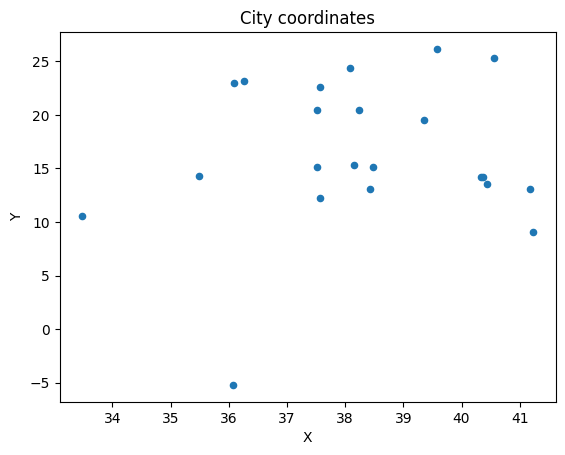

In [114]:
df.T.plot(kind = 'scatter', x='X', y='Y')
plt.title('City coordinates')
plt.show()

### Simulated Annealing

Here I have written a class which contains the nessecary functions to perform Simulated Annealing, inspired by the process of annealing in metallurgy in which metal is heated to a high temperature and then gradually cooled. We define functions which calculate the distance between two given cities as the euclidean norm, and another to calculate the total distance of the current route. We also define a temperature function which defines the annealing schedule, how the temperature is reduced throughout cycle, and a fucntion which generates 'neighbouring' candidate routes using the 2-opt algorithm. 
The temperature function is defined by the user. In this case, we use the following update rule:
$$T_{n+1} = T_{n}\cdot(1-\frac{\alpha}{N})$$
Where N is the user defined maximum number of iterations. As the temperature tends to zero, the algorithm converges to hill descent.

In [115]:
class Simulated_Annealing:
    
    def __init__(self, cities, max_iter=10000, init_temp=100, alpha=10):
        self.cities = cities
        self.max_iter = max_iter
        self.init_temp = init_temp
        self.alpha = alpha
        self.progress = []
        self.temp_history = [init_temp]
    
    # Returns euclidean distance between a pair of cities' coordinates
    def distance_between_cities(self, c1, c2):
        return math.dist(c1,c2)

    # Returns the total traversed distance of a candidate route
    def total_distance(self, route):
        distance = 0
        for i in range(len(route)-1):
            distance += self.distance_between_cities(route[i], route[i+1])
        distance += self.distance_between_cities(route[-1], route[0])
        return distance
    
    # Returns updated temperature according to defined annealing schedule.
    def temp_fn(self, temp, iter):
        return temp*(1-self.alpha/self.max_iter)

    # Returns a new candidate route using 2-opt
    def get_neighbour(self, route):
        i = random.randint(0, len(route) - 1)
        j = random.randint(i + 1, len(route))
        new_route = np.concatenate((route[:i], route[i:j+1][::-1], route[j+1:])) # Generate two cities and reverse traversal order between them
        return new_route

    # Performs simulated annealing
    def simulated_annealing(self):
        route = self.cities
        best_route = route
        current_distance = self.total_distance(best_route)
        best_distance = [current_distance]
        self.progress.append(current_distance)
        temp = self.init_temp
        iter = 0
        while iter < self.max_iter: # Continue until desired number of iterations is reached
            new_route = self.get_neighbour(route) # Get new candidate
            new_distance = self.total_distance(new_route)
            delta = new_distance - current_distance
            if delta < 0 or np.random.random() < np.exp(-delta/temp): # If candiate is better, accept it. If not better, sometimes accept anyway
                route = new_route                                                 
                current_distance = new_distance
                self.progress.append(current_distance)
            if current_distance < best_distance[-1]: # Check if this is the best so far
                best_route = route
                best_distance.append(current_distance)
            temp = self.temp_fn(temp, iter) # Update temperature
            self.temp_history.append(temp)
            iter += 1
        return best_distance, best_route

In [116]:
cities = df.T.to_numpy()
odyssey = Simulated_Annealing(cities)
best_distance, best_route = odyssey.simulated_annealing()
temps = odyssey.temp_history

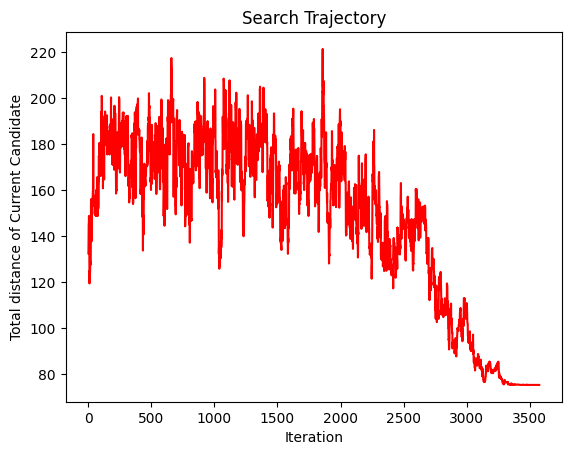

In [117]:
progress = odyssey.progress
plt.title("Search Trajectory")
plt.xlabel("Iteration")
plt.ylabel("Total distance of Current Candidate")
plt.plot(progress, color="red")
plt.show()

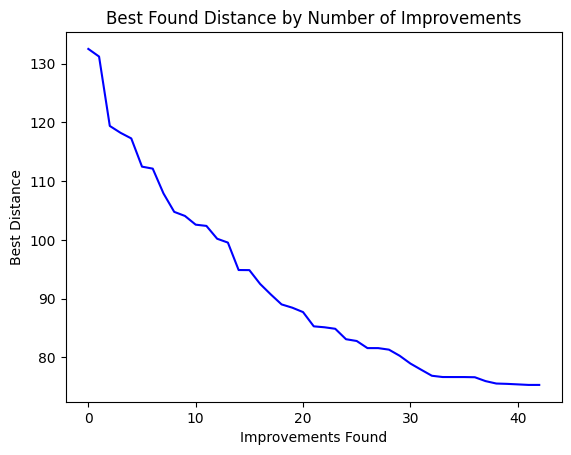

In [118]:
plt.title("Best Found Distance by Number of Improvements")
plt.xlabel("Improvements Found")
plt.ylabel("Best Distance")
plt.plot(best_distance, color="blue")
plt.show()

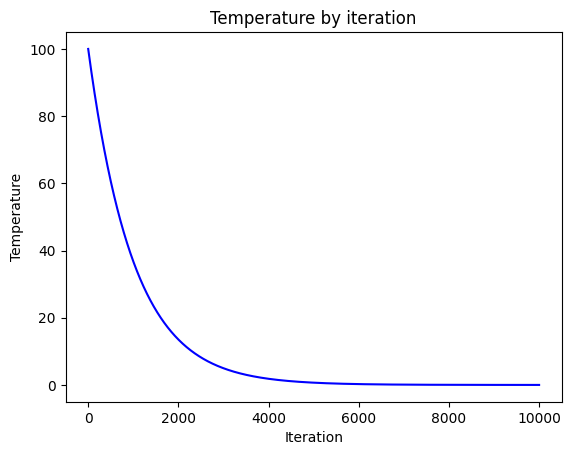

In [119]:
plt.title("Temperature by iteration")
plt.xlabel("Iteration")
plt.ylabel("Temperature")
plt.plot(temps, color="blue")
plt.show()

In [120]:
print(best_distance[-1])

75.30970120611255


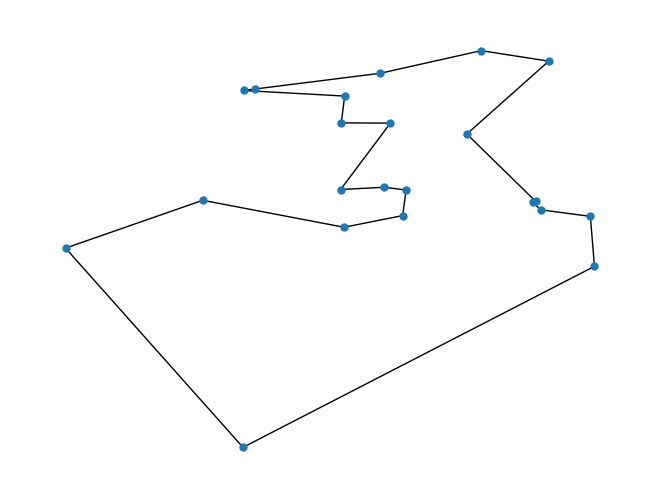

In [121]:
G = nx.Graph()

# Add nodes to graph
for i, coord in enumerate(best_route):
    G.add_node(i, pos=coord)

# Add edges to form a cycle
for i in range(len(best_route)):
    G.add_edge(i, (i+1) % len(best_route))

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Plot graph
nx.draw(G, pos, with_labels=False, node_size=25)
plt.show()

In [122]:
sa_distances = []
times = []
for i in range(30):
    start = time.time()
    odyssey = Simulated_Annealing(cities)
    best_distance, best_route = odyssey.simulated_annealing()
    sa_distances.append(best_distance[-1])
    end = time.time()
    times.append(end-start)

In [123]:
mean_times = np.mean(times)
print(mean_times)

0.4582033634185791


In [141]:
sa_distances = np.array(sa_distances)
mean_simulated_annealing = np.mean(sa_distances)
std_simulated_annealing = np.std(sa_distances)
print(mean_simulated_annealing, std_simulated_annealing)

# To save CSV
''' 
rounded_sa_distances = np.round(sa_distances, 3 - int(np.floor(np.log10(abs(sa_distances))).max()))
np.savetxt("SAData.csv", np.column_stack([np.arange(len(rounded_sa_distances)), rounded_sa_distances]), header='Test,Distance', delimiter=',', fmt='%d,%.3f')
'''

75.94881776508055 0.42305871831250325


### Genetic Algorithm

In [125]:
class GeneticAlgorithm:
    
    def __init__(self, cities, population_size=50, num_parents=20, beta=2):
        self.num_parents = num_parents
        self.cities = cities
        self.population_size = population_size
        self.beta = beta
        self.alpha = 2 - self.beta
        self.max_iter = math.floor((10000-self.population_size)/self.num_parents)
        self.pool = []
        self.progress = []
        self.fitness_calculations = 0
        for i in range(self.population_size):
            permutation = np.random.permutation((self.cities))
            self.pool.append([permutation, self.total_distance(permutation)])
             
    # Returns euclidean distance between a pair of cities' coordinates
    def distance_between_cities(self, c1, c2):
        return math.dist(c1,c2)

    # Returns the total traversed distance of a candidate route
    def total_distance(self, route):
        distance = 0
        for i in range(len(route)-1):
            distance += self.distance_between_cities(route[i], route[i+1])
        distance += self.distance_between_cities(route[-1], route[0])
        self.fitness_calculations += 1
        return distance
    
    # Returns a selection of parents with probability linearly proportional to ranking
    def select_parents(self, pool):
        pool.sort(key = lambda x: x[1], reverse=True) # Sort pool by total distance in descending order
        probabilities = np.empty(len(pool))
        for rank in range(len(pool)):
            probabilities[rank] = (self.alpha + (self.beta - self.alpha)*(rank/(len(pool)-1)))/len(pool) # Calculate linear ranking probabilities
        parents = []
        for i in range(self.num_parents):
            parents.append(pool[np.random.choice(len(pool), p=probabilities)]) # Randomly select parents proportional to probabilities
        return parents

    # Returns a number of mutations of the selected parents according to desired population size and number of selected parents
    def mutate(self, parents):
        mutations = []
        for parent in parents:
            i = random.randint(0, len(parent[0]) - 1)
            j = random.randint(i + 1, len(parent[0]))
            child = np.concatenate((parent[0][:i], parent[0][i:j+1][::-1], parent[0][j+1:])) # Generate two cities and perform 2-opt to mutate
            distance = self.total_distance(child)
            mutations.append([child, distance])
        return mutations
    
    # Performs Genetic Algorithm
    def genetic_algorithm(self):
        pool = self.pool
        iter = 0
        best_route = [sorted(pool, key = lambda x: x[1])[0]] # Sort by total distance in ascending order and take best route of pool
        while iter < self.max_iter:
            next_gen = []
            parents = self.select_parents(pool)
            children = self.mutate(parents)
            next_gen.extend(parents)
            next_gen.extend(children)
            for i in range(self.population_size - 2*self.num_parents): # Fill rest of pool to reach population size with randomly selected candidates from previous generation
                next_gen.append(pool[np.random.choice(len(pool))])
            pool = next_gen
            best_candidate = sorted(pool, key = lambda x: x[1])[0] # Find best candidate of pool
            self.progress.append(best_candidate) 
            if best_candidate[1] < best_route[-1][1]: # If candidate is the best found so far, add it as the new best route
                best_route.append(best_candidate)
            iter += 1
        return best_route 

In [126]:
ga_distances = []
times = []
for i in range(30):
    start = time.time()
    odyssey = GeneticAlgorithm(cities, beta = 2)
    best_distance = odyssey.genetic_algorithm()[-1][1]
    ga_distances.append(best_distance)
    end = time.time()
    times.append(end-start)

In [127]:
mean_times = np.mean(times)
print(mean_times)

0.7341591914494833


In [128]:
ga_distances = np.array(ga_distances)
mean_genetic_algorithm = np.mean(ga_distances)
std_genetic_algorithm = np.std(ga_distances)
print(mean_genetic_algorithm, std_genetic_algorithm)

# To save CSV
''' 
rounded_ga_distances = np.round(ga_distances, 3 - int(np.floor(np.log10(abs(ga_distances))).max()))
header = ['Test', 'Distance']
np.savetxt("GAData.csv", np.column_stack([range(len(rounded_ga_distances)), rounded_ga_distances]), header=','.join(header), delimiter=',', fmt='%.3f')
'''

76.7291817459897 0.708081754556545


In [129]:
# To save CSV
'''
test_index = range(len(sa_distances))
data = np.column_stack((test_index, rounded_sa_distances, rounded_ga_distances))
np.savetxt("Data.csv", data, delimiter=",", header="Test,SA,GA", fmt=["%d", "%.3f", "%.3f"], comments="")
'''

In [130]:
odyssey = GeneticAlgorithm(cities, population_size=50, num_parents=20, beta = 2)
best_route = odyssey.genetic_algorithm()
print(best_route[-1][1])

76.06494114319673


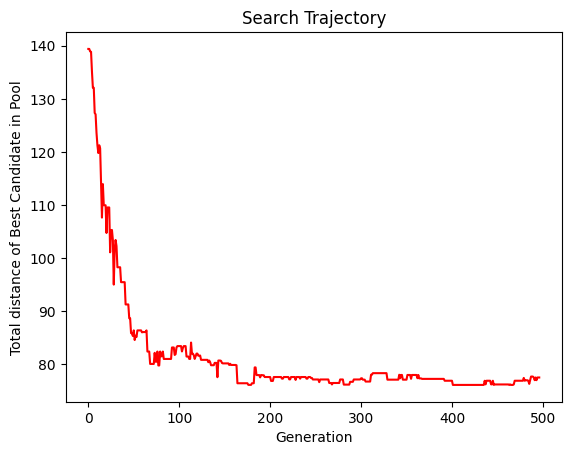

In [131]:
progress = [tup[1] for tup in odyssey.progress] # get the second element of each tuple
plt.title("Search Trajectory")
plt.xlabel("Generation")
plt.ylabel("Total distance of Best Candidate in Pool")
plt.plot(progress, color="red")
plt.show()

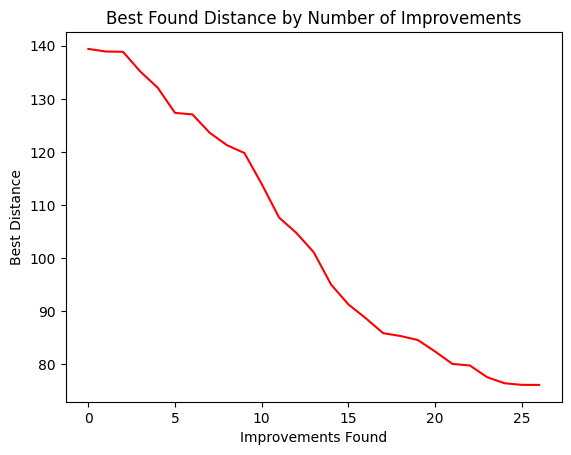

In [132]:
best_distances = [tup[1] for tup in best_route]
plt.title("Best Found Distance by Number of Improvements")
plt.xlabel("Improvements Found")
plt.ylabel("Best Distance")
plt.plot(best_distances, color="red")
plt.show()

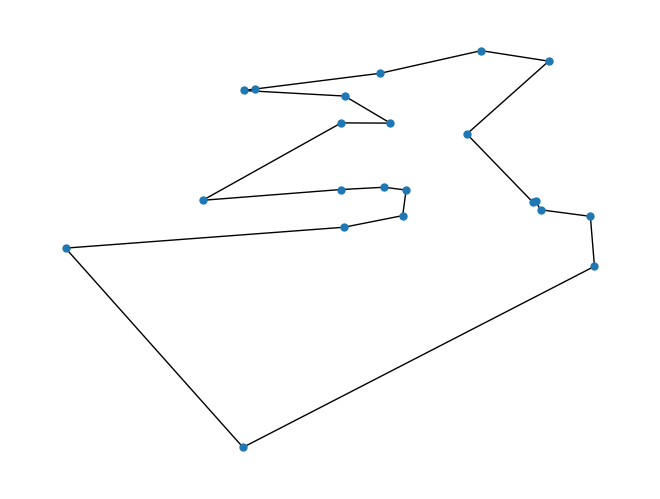

In [133]:
G = nx.Graph()

# Add nodes to graph with their coordinates as attributes
for i, coord in enumerate(best_route[-1][0]):
    G.add_node(i, pos=coord)

# Add edges to form a cycle
for i in range(len(best_route[-1][0])):
    G.add_edge(i, (i+1) % len(best_route[-1][0]))

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Plot graph
nx.draw(G, pos, with_labels=False, node_size=25)
plt.show()

#### Wilcoxon Signed Rank Test

$$H_{0}: F(x,\ y) = F(y,\ x)$$

$$H_{1}: \text{For some}\ \mu \neq 0,\ F(x , y) = F(y + \mu,\ x - \mu)$$

We will use a two-tailed significance level of 5%, $$\alpha2 = 0.05$$
which corresponds to a critical value of 137 using a table.

In [134]:
diffs = sa_distances - ga_distances

# Sort the absolute values of diffs in ascending order and get the sorted indices
sorted_indices = np.argsort(np.abs(diffs))

# Use the sorted indices to get the elements of diffs in ascending order by absolute value
ranked_diffs = diffs[sorted_indices]
print(ranked_diffs)

[-1.42108547e-14  2.19117351e-03 -8.87063899e-02 -2.53558434e-01
  3.56897414e-01 -4.03084901e-01 -4.57245180e-01  4.98840899e-01
 -5.11398873e-01 -5.74681135e-01 -5.93517055e-01 -6.61142698e-01
  6.72548447e-01 -6.89743630e-01 -7.58609006e-01 -7.66731750e-01
 -8.41058159e-01 -8.69279596e-01 -9.49404190e-01 -1.07142962e+00
 -1.14345301e+00 -1.14870371e+00 -1.42113737e+00 -1.44914371e+00
 -1.49884116e+00 -1.51415101e+00 -1.53127417e+00 -1.56537529e+00
 -1.64942719e+00 -2.53030012e+00]


In [135]:
ranks = np.arange(len(ranked_diffs)) + 1
T = np.sum(ranks * np.sign(ranked_diffs))

t_minus = np.sum(ranks[ranked_diffs < 0])
t_plus = np.sum(ranks[ranked_diffs > 0])

print('T_plus =', t_plus)
print('T_minus =', t_minus)
print('T =', T)
test = min(t_plus, t_minus)
print('Test statistic = min(T_plus, T_minus) = ', test)

T_plus = 28
T_minus = 437
T = -409.0
Test statistic = min(T_plus, T_minus) =  28


In [136]:
z = 137
if abs(T) < z:
    print(abs(T), '<', z, 'So cannot reject null hypothesis.')
elif abs(T) > z:
    print(abs(T), '>', z, 'So reject null hypothesis.')

409.0 > 137 So reject null hypothesis.


We can do this easily with scipy.

In [137]:
from scipy.stats import wilcoxon
alpha = 0.025
statistic, p = wilcoxon(diffs, alternative='two-sided')
print('Test statistic = ', statistic)
print('p =', p)
if p < alpha:
    print(p, '<', alpha, 'So reject null hypothesis.')
else:
    print(p, '>', alpha, 'So cannot reject null hypothesis.')

Test statistic =  28.0
p = 2.7623027563095093e-06
2.7623027563095093e-06 < 0.025 So reject null hypothesis.
